In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_hdf('./cell_types_data.h5')

### Use the normalized data

Shape is (cells, sample_at_timepoint)

In [3]:
data = np.vstack(df._NORMALIZE)
data.shape

(143, 2990)

### Examples of what the data look like

The goal is to quantitatively group together similar dynamics and separate disparate dynamics in order to see if distinct cells exhibit stereotyped dynamics.

You could by eye say that 2 and 3 are more similar to each other, and 1 and 4 and more similar to each other but we need a quantitative way to do this.

(-149.45000000000002, 3138.45, -0.05, 1.05)

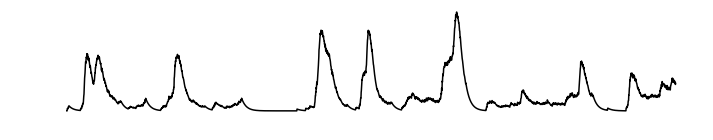

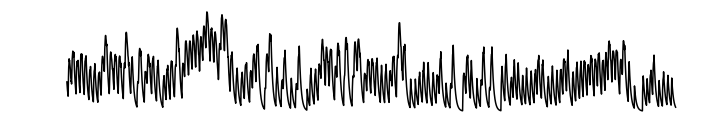

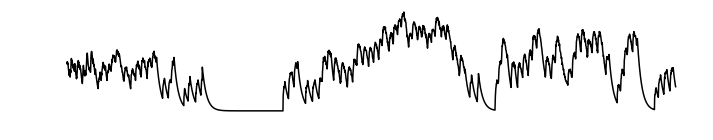

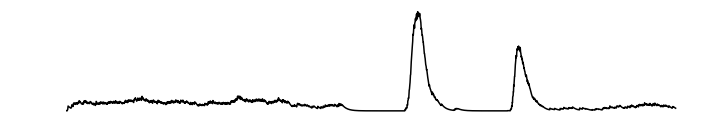

In [4]:
fig = plt.figure(figsize=(12,2))
plt.plot(data[15], c='k');plt.axis('off')

fig = plt.figure(figsize=(12,2))
plt.plot(data[32], c='k');plt.axis('off')

fig = plt.figure(figsize=(12,2))
plt.plot(data[126], c='k');plt.axis('off')

fig = plt.figure(figsize=(12,2))
plt.plot(data[1], c='k');plt.axis('off')

### Plot all the data in the form of a heatmap

Each row is a recording from a cell (data similar to the above image)

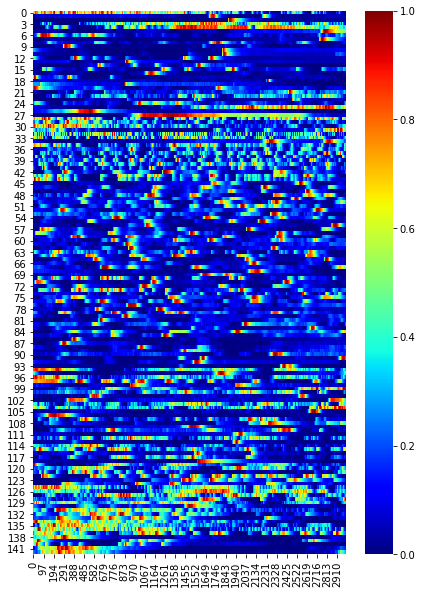

In [5]:
fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(111)
sns.heatmap(data, cmap='jet', ax=ax)

### Take the log of the absolute value of the discrete fourier transform of all these data

This seems very similar to L1 Regularization you presented.

Uses scipy.fftpack.rfft: https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.rfft.html

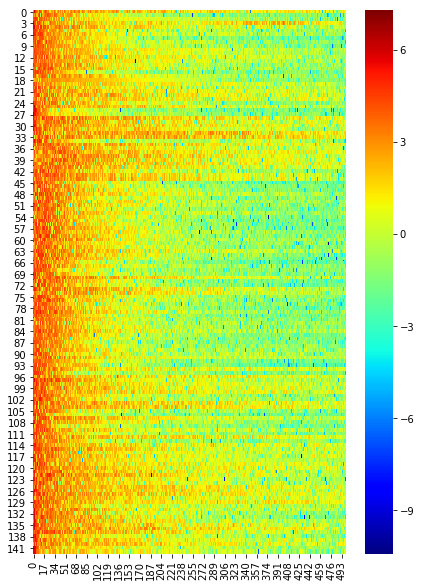

In [6]:
from scipy.fftpack import rfft

f_data = rfft(data) # DFT

log_f_data = np.log(np.abs(f_data))

# Take only 500 frequency domains, corresponding to 1.67Hz. The higher domains are likely to be noise
log_f_data = log_f_data[:, :500]

# Plot the ldata
fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(111)
sns.heatmap(log_f_data, cmap='jet', ax=ax)

### The representation of the data in frequency space seems much more useful

### Perform hiearchical clustering using the Wasserstein Distance : https://en.wikipedia.org/wiki/Wasserstein_metric

The Wasserstein Distance is basically "the minimal amount of work that must be done to transform one distribution into the other by moving distribution mass".

These are all highly tailed distributions.

Also, frequency domains which are next to each other are more similar than those which are further apart. 

Therefore this metric seems like a useful measure.

In [ ]:
from scipy.stats import wasserstein_distance
from scipy.cluster.hierarchy import linkage

# Calculate linkage matrix
Z = linkage(log_f_data, metric=wasserstein_distance, method='complete', optimal_ordering=True)

# Plot the data along with the dendrogram
sns.clustermap(log_f_data, row_cluster=True, row_linkage=Z, col_cluster=False, cmap='jet')

### Same as above but plotting the original data from the first heatmap

In [ ]:
sns.clustermap(data, row_cluster=True, row_linkage=Z, col_cluster=False, cmap='jet')

## The following images illustrate the Wasserstein Distance between some similar curves to show its usefulness

### I've called Wasserstein Distance as EMD (Earth Mover's Distance) in these images. It's just another name for the same thing.

### Description:

**Top: 4 curves**

**Heatmap 1: Heatmap to illustrate the EMD between the DFT of the 4 curves.**

We can see that the EMD between these curves is very small (the distance scale, illustrated by the colormap, is relative to the entire dataset this is from)

**Heatmap 2: Heatmap to illustrate the Euclidean distance between the DFT of the 4 curves.**

**Heatmap 3: Heatmap to illustrate the Euclidean distance between the 4 curves.**

We can see that the Euclidean distance does not capture the similarity in dynamics between these curves

![one](./very_similar.png)

### Another set of examples to illustrate similarity

**Here we can see that the fine differences between them are also captured by the EMD**

![two](./similar.png)

### Lastly, EMD captures disparate dynamics as well

![three](./different.png)